In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


In [2]:
df_tweets = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")
df_tweets[:10]

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [3]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7961
gender,7973
not_cyberbullying,7945
other_cyberbullying,7823
religion,7998


## Data Cleaning

### Checking Missing Values

In [4]:
def check_missing_values(col):
    counter = 0
    for element in col:
        if element == True:
            counter += 1
    return counter

In [5]:
df_tweets.isnull().apply(lambda x: check_missing_values(x))

tweet_text            0
cyberbullying_type    0
dtype: int64

### Checking Duplicates

In [6]:
def check_duplicated_values(x):
    return x.duplicated().sum()

In [7]:
df_tweets.apply(lambda x: check_duplicated_values(x))

tweet_text             1675
cyberbullying_type    47686
dtype: int64

In [8]:
df_tweets.loc[:,["tweet_text"]].duplicated().sum()

1675

In [9]:
df_tweets = df_tweets.drop_duplicates(subset=['tweet_text'])

In [10]:
df_tweets.apply(lambda x: check_duplicated_values(x))

tweet_text                0
cyberbullying_type    46011
dtype: int64

In [11]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


## Data Transformation

### Balancing the Dataset

In [12]:
df_tweets = df_tweets.groupby(by="cyberbullying_type").sample(n=1000, random_state=1)
print("Length: "+ str(len(df_tweets)))
df_tweets[:5]

Length: 6000


,tweet_text,cyberbullying_type
34044,She looks so beautiful and she’s has a very ki...,age
38234,My old high school bully just tried to menace ...,age
36306,From my experience PE teachers are bullies. I ...,age
36793,ew why is gun/poop girl trending literally go ...,age
37263,Lara Spencer is so unprofessional. She bullied...,age


In [13]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,1000
ethnicity,1000
gender,1000
not_cyberbullying,1000
other_cyberbullying,1000
religion,1000


### Splitting Test and Train/Validation sets
I will create a test set. A set not touched to evaluation later on the model performance.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_x_tv, df_x_test, df_y_tv, df_y_test = train_test_split(df_tweets['tweet_text'], df_tweets['cyberbullying_type'], test_size=0.20,
                                                                            random_state=42)

## Data Preprocessing
We are going to create a list of tokens to be used in the DNN model. A term-document to be used as input into the model. Furthermore, we have 2 version to test one with stop words and another without them. Evaluation which approach get better accuracy. Version 1 will use the stop words. Version 2 will not use them.

### Tokenization

In [16]:
import spacy

nlp = spacy.load('en_core_web_sm')

# to be used in the without stopwords version
all_stopwords = nlp.Defaults.stop_words 

In [17]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [18]:
#!pip install contextualSpellCheck

In [19]:
#import contextualSpellCheck

# Add contextual spell check to pipeline, the gramatical police
#nlp.add_pipe("contextual spellchecker", config={"max_edit_dist": 3}) 

In [20]:
# Remove URLs
def remove_urls(text):
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    return text

In [21]:
import re

def tokenize_stopwords(cell):
    nlp_text = nlp(cell)
    tokens = [remove_urls(token.text).lower() for token in nlp_text if token.text.isalnum()]
    return tokens

def tokenize_without_stopwords(cell):
    nlp_text = nlp(cell)
    tokens = [remove_urls(token.text).lower() for token in nlp_text if token.text.isalnum() and not token.text in all_stopwords]
    return tokens

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

term_doc_m_v1 = CountVectorizer(tokenizer=tokenize_stopwords,max_df=0.8,min_df=0.01,max_features=4000)
term_doc_m_v2 = CountVectorizer(tokenizer=tokenize_without_stopwords,max_df=0.8,min_df=0.01,max_features=4000)

In [23]:
term_doc_m_v1.fit(df_x_tv)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


CountVectorizer(max_df=0.8, max_features=4000, min_df=0.01,
                tokenizer=<function tokenize_stopwords at 0x7fe396fc9050>)

In [24]:
len(term_doc_m_v1.get_feature_names_out())

277

In [25]:
term_doc_m_v2.fit(df_x_tv)

CountVectorizer(max_df=0.8, max_features=4000, min_df=0.01,
                tokenizer=<function tokenize_without_stopwords at 0x7fe396fc9a70>)

In [26]:
len(term_doc_m_v2.get_feature_names_out())

140

In [27]:
df_x_v1 = term_doc_m_v1.transform(df_x_tv)
df_x_v1.shape

(4800, 277)

In [28]:
df_x_v2 = term_doc_m_v2.transform(df_x_tv)
df_x_v2.shape

(4800, 140)

In [29]:
df_x_test_v1 = term_doc_m_v1.transform(df_x_test)
df_x_test_v1.shape

(1200, 277)

In [30]:
df_x_test_v2 = term_doc_m_v2.transform(df_x_test)
df_x_test_v2.shape

(1200, 140)

### Hot Encoding

In [31]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_tweets['cyberbullying_type'])
print('Labels: ', label_encoder.classes_)


def label_encode(labels):
    encoding = label_encoder.transform(labels)
    return tf.keras.utils.to_categorical(encoding,len(label_encoder.classes_))


def label_decode(labels):
    decoding = np.argmax(labels, axis=1)
    return label_encoder.inverse_transform(decoding)

Labels:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'
 'religion']


In [32]:
label_encode(['age', 'ethnicity' ,'gender', 'not_cyberbullying' ,'other_cyberbullying','religion'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [33]:
df_y = label_encode(df_y_tv)
df_y[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [34]:
df_y_test = label_encode(df_y_test)
df_y_test[:5]

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

### spliting the dataset in the train, validation and testing sets
lets get our train, validation, and test sets

In [35]:
from sklearn.model_selection import train_test_split

#### Version 1

In [36]:
df_x_train_v1, df_x_valid_v1, df_y_train_v1, df_y_valid_v1 = train_test_split(df_x_v1, df_y, test_size=0.30,
                                                                            random_state=42)

#### Version 2

In [37]:
df_x_train_v2, df_x_valid_v2, df_y_train_v2, df_y_valid_v2 = train_test_split(df_x_v2, df_y, test_size=0.30,
                                                                            random_state=42)

In [38]:
counter = {}

labels = ['age', 'ethnicity' ,'gender', 'not_cyberbullying' ,'other_cyberbullying','religion']
comparater = label_encode(labels)

#init
def initCounter():
    for i in label_encoder.classes_:
        counter[i] = 0

def countCategories(x):
    for idx, y in enumerate(comparater):
        if (x == y).all():
            counter[labels[idx]] = counter[labels[idx]] + 1
            return          

In [39]:
initCounter()
for i in df_y_train_v1:
    countCategories(i)
    
counter

{'age': 552,
 'ethnicity': 525,
 'gender': 575,
 'not_cyberbullying': 556,
 'other_cyberbullying': 590,
 'religion': 562}

In [40]:
initCounter()
for i in df_y_valid_v1:
    countCategories(i)
    
counter   

{'age': 233,
 'ethnicity': 253,
 'gender': 249,
 'not_cyberbullying': 240,
 'other_cyberbullying': 221,
 'religion': 244}

In [41]:
initCounter()
for i in df_y_test:
    countCategories(i)
    
counter  

{'age': 215,
 'ethnicity': 222,
 'gender': 176,
 'not_cyberbullying': 204,
 'other_cyberbullying': 189,
 'religion': 194}

## Modeling

In [42]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)
#regularizer = tf.keras.regularizers.l1_l2(0.001, 0)
classes_len = len(label_encoder.classes_)

### Creating Models
#### Version 1

In [43]:
input_shape_v1 = len(term_doc_m_v1.get_feature_names())

model_v1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape_v1,)),
    tf.keras.layers.Dense(500, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(50, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(classes_len, kernel_regularizer=regularizer),
    tf.keras.layers.Softmax()
])

model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               139000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 3

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-10-02 01:34:15.375021: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Version 2

In [44]:
input_shape_v2 = len(term_doc_m_v2.get_feature_names())

model_v2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape_v2,)),
    tf.keras.layers.Dense(500, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(200, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(50, kernel_regularizer=regularizer, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(classes_len, kernel_regularizer=regularizer),
    tf.keras.layers.Softmax()
])

model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 500)               70500     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                

### Compiling Models

In [45]:
model_v1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

### Training
#### Hyperparameters

In [46]:
epoch = 15
batch = 40

#### Version 1

In [47]:
history1 = model_v1.fit(df_x_train_v1, df_y_train_v1, epochs=epoch, batch_size=batch, validation_data=(df_x_valid_v1,df_y_valid_v1))

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 500), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
2022-10-02 01:34:16.809763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


84/84 [==============================] - 3s 15ms/step - loss: 1.9115 - accuracy: 0.5557 - val_loss: 1.3311 - val_accuracy: 0.7333
Epoch 2/15
84/84 [==============================] - 1s 11ms/step - loss: 1.1852 - accuracy: 0.7625 - val_loss: 1.1258 - val_accuracy: 0.7750
Epoch 3/15
84/84 [==============================] - 1s 11ms/step - loss: 0.9979 - accuracy: 0.8054 - val_loss: 1.0196 - val_accuracy: 0.7951
Epoch 4/15
84/84 [==============================] - 1s 11ms/step - loss: 0.8922 - accuracy: 0.8310 - val_loss: 0.9698 - val_accuracy: 0.7903
Epoch 5/15
84/84 [==============================] - 1s 11ms/step - loss: 0.7919 - accuracy: 0.8488 - val_loss: 0.9424 - val_accuracy: 0.7993
Epoch 6/15
84/84 [==============================] - 1s 11ms/step - loss: 0.7169 - accuracy: 0.8720 - val_loss: 0.9161 - val_accuracy: 0.7965
Epoch 7/15
84/84 [==============================] - 1s 11ms/step - loss: 0.6483 - accuracy: 0.8958 - val_loss: 0.9111 - val_accuracy: 0.7937
Epoch 8/15
84/84 [======

#### Version 2

In [48]:
history2 = model_v2.fit(df_x_train_v2, df_y_train_v2, epochs=epoch, batch_size=batch, 
                        validation_data=(df_x_valid_v2,df_y_valid_v2))

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_5/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_5/embedding_lookup_sparse/Reshape:0", shape=(None, 500), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_5/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


84/84 [==============================] - 2s 12ms/step - loss: 1.6370 - accuracy: 0.6250 - val_loss: 1.1143 - val_accuracy: 0.7493
Epoch 2/15
84/84 [==============================] - 1s 9ms/step - loss: 1.0088 - accuracy: 0.7810 - val_loss: 1.0031 - val_accuracy: 0.7833
Epoch 3/15
84/84 [==============================] - 1s 10ms/step - loss: 0.8634 - accuracy: 0.8030 - val_loss: 0.8965 - val_accuracy: 0.8028
Epoch 4/15
84/84 [==============================] - 1s 9ms/step - loss: 0.7929 - accuracy: 0.8131 - val_loss: 0.8211 - val_accuracy: 0.7924
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.7215 - accuracy: 0.8185 - val_loss: 0.8279 - val_accuracy: 0.7903
Epoch 6/15
84/84 [==============================] - 1s 9ms/step - loss: 0.6911 - accuracy: 0.8244 - val_loss: 0.7866 - val_accuracy: 0.8000
Epoch 7/15
84/84 [==============================] - 1s 9ms/step - loss: 0.6450 - accuracy: 0.8354 - val_loss: 0.7500 - val_accuracy: 0.7951
Epoch 8/15
84/84 [==========

### Visualization Training Results

In [49]:
import matplotlib.pyplot as plt

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

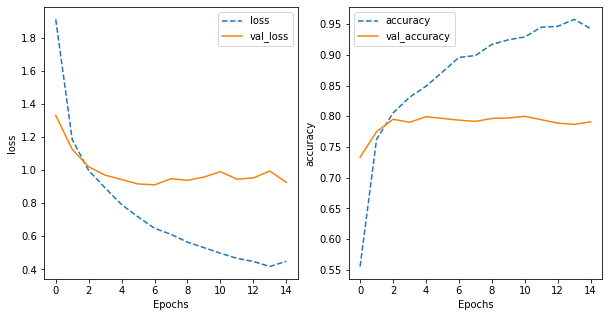

In [50]:
training_plot(['loss', 'accuracy'], history1)

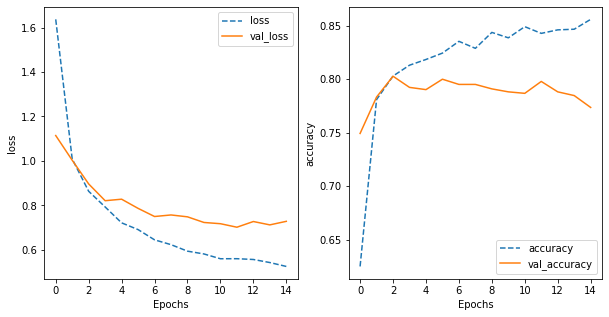

In [51]:
training_plot(['loss', 'accuracy'], history2)

### Predictions

In [52]:
## predict
df_y_test_v1_pred = model_v1.predict(df_x_test_v1)
df_y_test_v2_pred = model_v2.predict(df_x_test_v2)

### Visualization Predictions

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [54]:
# Funtion for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    classes.sort()
    tick_marks = np.arange(len(classes))    
    plt.figure(figsize=(4, 4),dpi=115)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Version 1

In [55]:
pred_result = label_decode(df_y_test_v1_pred) 
true_result = label_decode(df_y_test)
print(classification_report(y_true=true_result, y_pred=pred_result))

                     precision    recall  f1-score   support

                age       0.96      0.96      0.96       215
          ethnicity       0.96      0.96      0.96       222
             gender       0.74      0.77      0.75       176
  not_cyberbullying       0.51      0.47      0.49       204
other_cyberbullying       0.48      0.48      0.48       189
           religion       0.88      0.92      0.90       194

           accuracy                           0.77      1200
          macro avg       0.75      0.76      0.76      1200
       weighted avg       0.76      0.77      0.76      1200



Confusion matrix, without normalization


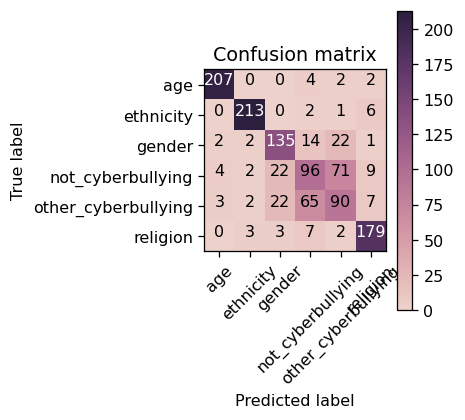

In [56]:
# plot confusion matrix
cm = confusion_matrix(y_true=true_result, y_pred=pred_result) 
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')

### Version 2

In [57]:
pred_result = label_decode(df_y_test_v2_pred)
true_result = label_decode(df_y_test)
print(classification_report(y_true=true_result, y_pred=pred_result))

                     precision    recall  f1-score   support

                age       1.00      0.95      0.97       215
          ethnicity       0.97      0.95      0.96       222
             gender       0.94      0.65      0.77       176
  not_cyberbullying       0.53      0.50      0.52       204
other_cyberbullying       0.47      0.69      0.56       189
           religion       0.95      0.92      0.93       194

           accuracy                           0.79      1200
          macro avg       0.81      0.78      0.79      1200
       weighted avg       0.82      0.79      0.79      1200



Confusion matrix, without normalization


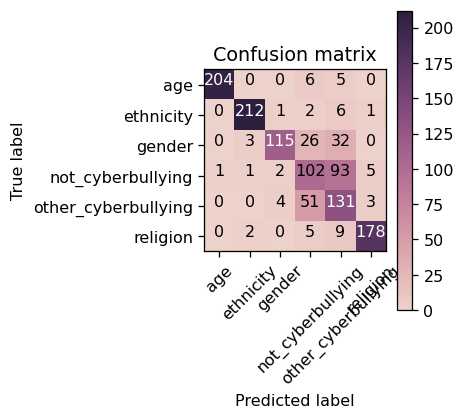

In [58]:
# plot confusion matrix
cm = confusion_matrix(y_true=true_result, y_pred=pred_result) 
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')

## Final Thoughts
I got better results in the testing of the second version, where we eliminate the stop words. We have less overfitting. The real challenge in both models is separate: not cyberbullying vs other cyberbullying. Because the category other_cyberbullying doesn't belong to some specific category. Its scope is bigger than the other categories, making it difficult to difference its key patterns. 

It is important to note, that the dimensionality used in the input differs. Furthermore, we use a minimun frequency value to avoid terms that ocurred less than 1%, or terms that ocurred over 80% of the dataset.